# Regression Open-Ended Project

-----

# Previous Notebooks

- Web Scraping
- Cleaning data
- Exploratory Data Analysis
- Feature Engineering
- Further Explatory Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [120]:
df = pickle.load(open('../data/processed/ebert_imdb_final_df.pkl', 'rb'))

In [121]:
# Create feature column
df['Watchable'] = df['EbertStars'].apply(lambda x: 1 if x >= 3.0 else 0)

# Only Ebert rated
df = df[df['Year'] < 2013]

# Selecting the desired variables
df = df[['IMDB_Rating', 'Rating_Count', 'Metascore',
       'User_Review_Count', 'Critic_Review_Count', 'Runtime',
        'Foreign', 'UC_Ratio', 'Description_Len', 'Season', 'Watchable']]

# Removing any missing rows
df = df.dropna()

In [122]:
# Keep test set away till final model
train, test = train_test_split(df, test_size=0.25)

In [152]:
# Create X and y data sets
movie = train.drop("Watchable", axis=1)
movie_labels = train["Watchable"].copy()

In [153]:
# Standardize continuous variables
movie_cont = movie.drop(['Foreign', 'Season'], axis=1)
stdsc = StandardScaler()
movie_cont_sc = stdsc.fit_transform(movie_cont.values)

movie_cont = pd.DataFrame(movie_cont_sc, index=movie_cont.index, columns=movie_cont.columns)
movie_sc = pd.concat([movie_cont, movie[['Foreign', 'Season']]], axis=1, join='inner')

In [154]:
# Convert season into dummy variables
movie_sc = pd.concat([movie_sc.drop('Season', axis=1), pd.get_dummies(movie_sc['Season'])], axis=1)

In [155]:
movie_sc = movie_sc.sort_index()
movie_sc.head()

,IMDB_Rating,Rating_Count,Metascore,User_Review_Count,Critic_Review_Count,Runtime,UC_Ratio,Description_Len,Foreign,Fall,Spring,Summer,Winter
47,1.174393,-0.549176,0.784078,-0.657609,-0.009183,-0.136069,-1.126488,0.114052,1,0,0,1,0
150,1.174393,0.472176,1.871146,0.268575,0.613629,2.521599,-0.049264,0.114052,0,1,0,0,0
196,-1.621411,-0.537778,-1.390058,-0.641168,-1.007516,1.277584,-0.352945,-0.030196,0,0,0,1,0
299,-1.388428,0.168022,-1.510843,1.013907,2.308047,0.938307,-0.159009,-0.246568,0,0,1,0,0
392,-0.805968,0.500960,-0.604953,1.033088,0.668583,-0.531892,0.817044,0.691044,0,0,1,0,0


In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(movie_sc, movie_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, movie_sc, movie_labels, cv=3, scoring="accuracy")

array([ 0.58 ,  0.547,  0.587])

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, movie_sc, movie_labels, cv=3)

In [14]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(movie_labels, y_train_pred)

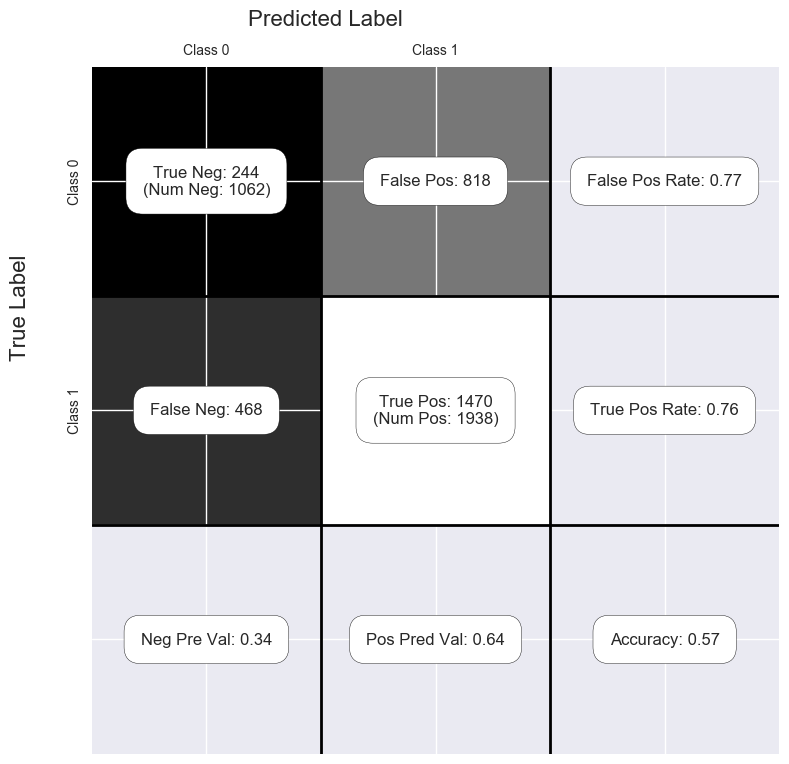

In [16]:
show_confusion_matrix(C, ['Class 0', 'Class 1'])

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(movie_labels, y_train_pred)

0.6424825174825175

In [18]:
recall_score(movie_labels, y_train_pred)

0.75851393188854488

In [19]:
from sklearn.metrics import f1_score

f1_score(movie_labels, y_train_pred)

0.69569332702318987

In [20]:
y_scores = cross_val_predict(sgd_clf, movie_sc, movie_labels, cv=3, method="decision_function")

In [21]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(movie_labels, y_scores)

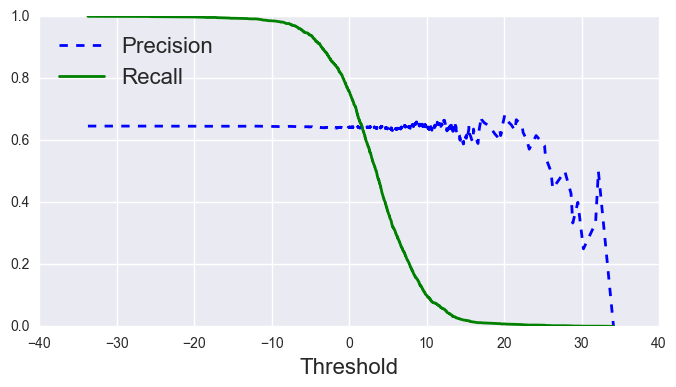

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

LinearSVM


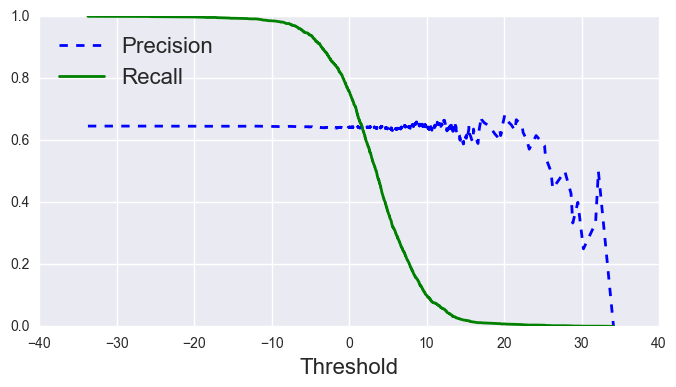

LogisticRegression


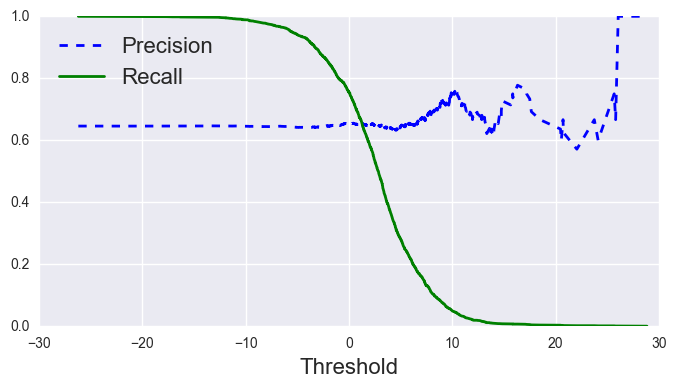

GradientBoostingClassifier


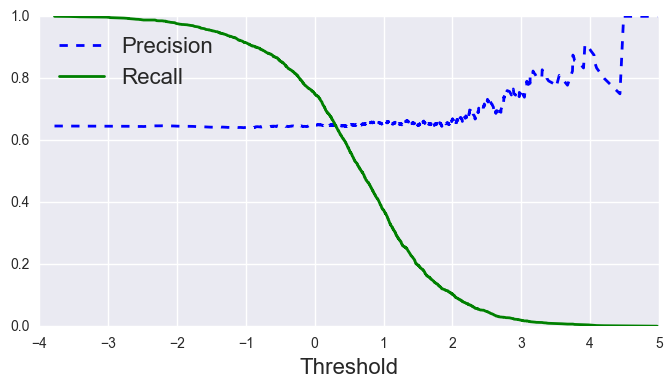

In [87]:
linear_svm_clf = SGDClassifier(loss="hinge", random_state=42)
log_reg_clf = SGDClassifier(loss="log", random_state=42)
grd_clf = GradientBoostingClassifier(n_estimators=500, random_state=42)

classifiers = [('LinearSVM', linear_svm_clf), 
               ('LogisticRegression', log_reg_clf),
               ('GradientBoostingClassifier', grd_clf)]

for name, clf in classifiers:
    y_scores = cross_val_predict(clf, movie_sc, movie_labels, cv=3, method="decision_function")

    if y_scores.ndim == 2:
        y_scores = y_scores[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(movie_labels, y_scores)
    
    print(name)
    plt.figure(figsize=(8, 4))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()

To maximize precision, recall would go close to 0. It would be a high trade-off. I would like to target at least 80% precision so that 8/10 movies I watch would be equivalent to an Ebert 3.0 or better.

In [95]:
from sklearn.model_selection import GridSearchCV

# Grid search
param_test = {'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)}
gs = GridSearchCV(estimator = GradientBoostingClassifier(
        learning_rate=0.1, min_samples_split=500 ,min_samples_leaf=50,
        max_depth=8, max_features='sqrt', subsample=0.8, random_state=42), 
        param_grid = param_test, scoring='precision', n_jobs=4, iid=False, cv=5)

gs.fit(movie_sc, movie_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': range(30, 71, 10), 'min_samples_split': range(1000, 2100, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

In [98]:
gs.best_params_, gs.best_score_

({'min_samples_leaf': 50, 'min_samples_split': 1200}, 0.64890847318006506)

In [143]:
from sklearn.metrics import accuracy_score

In [150]:
# Test final model
final_model = gs.best_estimator_

X_test = test.drop("Watchable", axis=1)
y_test = test["Watchable"].copy()

In [151]:
# Standardize continuous variables
test_cont = X_test.drop(['Foreign', 'Season'], axis=1)
stdsc = StandardScaler()
test_cont_sc = stdsc.fit_transform(test_cont.values)
test_cont = pd.DataFrame(test_cont_sc, index=test_cont.index, columns=test_cont.columns)
test_sc = pd.concat([test_cont, X_test[['Foreign', 'Season']]], axis=1, join='inner')

test_sc = pd.concat([test_sc.drop('Season', axis=1), pd.get_dummies(test_sc['Season'])], axis=1)
test_sc = test_sc.sort_index()

final_predictions = final_model.predict(test_sc)

print("Precision", precision_score(y_test, final_predictions))
print("Recall", recall_score(y_test, final_predictions))
print("Accuracy", accuracy_score(y_test, final_predictions))

Precision 0.630081300813
Recall 0.985691573927
Accuracy 0.627372627373


In [158]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(movie_sc, movie_labels)
clf.score(test_sc, y_test)  

0.62837162837162841

# Conclusions, Lessons Learned and Further Research

In the end, the modeling approach performed as well as a dummy classifier that simply picked the most common class. I could definitely shift the threshold in favor of precision, but recall would plummet to 0. In this example, I'd rather watch only good movies and have a few false positives (bad movies recommended), even if that means missing a bunch of good ones. However, in a realistic scenario, an extreme decision approach would not be recommended.

It may be impossible to model Roger Ebert's interpretation of movies. Although many movies are generally accepted as true, there is a fair amount of subjectivity when it comes to critiquing movies. Most likely, I would need to add better features. Off the top of my head, using natural language processing to extract topics, keywords and sentiment could definitely hit at whether the review is positive or negative.

At the same time, I realize that many of the features may not be available at the time of movie release and some of them are available within 2 weeks or even 2 months after the theatrical release. I'd need to narrow down the evaluation metric and features that would be usable if I were to continue working on this project.